In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
import scipy.stats as stats
from functools import partial

import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as scp
import statsmodels.iolib.summary2 as iosm2

import statsmodels.formula.api as smf
import sklearn.linear_model as sklm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import calendar

In [2]:
stock_list = pd.read_csv("./Data/RESSET_IDXCOMPO_1.csv",encoding="GB2312")
stock_list["结束日期_EndDt"] = stock_list["结束日期_EndDt"].fillna("2023/5/28")
stock_list["结束日期_EndDt"] = pd.to_datetime(stock_list["结束日期_EndDt"])
stock_list["开始日期_BegDt"] = pd.to_datetime(stock_list["开始日期_BegDt"])
stock_list = stock_list["证券代码_成分_SecuCd_Compo"].loc[(stock_list["结束日期_EndDt"] >= pd.to_datetime("2018-05-01"))].values.tolist()
stock_list

[8,
 66,
 301,
 408,
 408,
 553,
 596,
 627,
 629,
 656,
 661,
 671,
 703,
 708,
 723,
 723,
 723,
 733,
 786,
 792,
 800,
 839,
 860,
 877,
 898,
 938,
 959,
 961,
 977,
 983,
 1289,
 1965,
 2001,
 2010,
 2027,
 2032,
 2044,
 2049,
 2050,
 2064,
 2074,
 2074,
 2085,
 2120,
 2129,
 2157,
 2174,
 2179,
 2180,
 2271,
 2294,
 2310,
 2311,
 2352,
 2371,
 2384,
 2410,
 2411,
 2414,
 2422,
 2424,
 2426,
 2459,
 2460,
 2463,
 2466,
 2466,
 2468,
 2493,
 2508,
 2555,
 2558,
 2568,
 2572,
 2600,
 2601,
 2602,
 2607,
 2608,
 2624,
 2625,
 2648,
 2709,
 2714,
 2739,
 2756,
 2773,
 2791,
 2797,
 2812,
 2821,
 2831,
 2839,
 2841,
 2841,
 2916,
 2920,
 2925,
 2938,
 2939,
 2945,
 2958,
 3816,
 300003,
 300014,
 300015,
 300033,
 300072,
 300122,
 300136,
 300142,
 300207,
 300223,
 300274,
 300296,
 300316,
 300347,
 300408,
 300413,
 300433,
 300450,
 300454,
 300496,
 300498,
 300529,
 300558,
 300595,
 300601,
 300628,
 300661,
 300676,
 300677,
 300750,
 300751,
 300759,
 300760,
 300763,
 30076

In [3]:
stock_list = [str(i).rjust(6,"0") for i in stock_list]

In [4]:
def get_last_day(date_str):
    # 将字符串转换为datetime对象，并获取对应年份和月份
    dt = datetime.strptime(date_str, "%Y%m")
    year = dt.year
    month = dt.month

    # 计算该月份的天数（包括闰年的情况）
    days_in_month = calendar.monthrange(year, month)[1]

    # 返回该月份的最后一天
    return datetime(year, month, days_in_month)

In [5]:
data = pd.read_csv("./Data/hs300_5T.csv")
data["time"] = pd.to_datetime(data["time"])
data["year"] = data["time"].dt.year
data["mon"] = data["time"].dt.month
data["day"] = data["time"].dt.day
data["ymd"] = data["year"].apply(lambda x:str(x))+data["mon"].apply(lambda x:str(x).rjust(2,"0"))+data["day"].apply(lambda x:str(x))
data["ym"] = data["year"].apply(lambda x:str(x))+data["mon"].apply(lambda x:str(x).rjust(2,"0"))
data["r"] = data.groupby("ymd",group_keys=False)["close"].apply(lambda x:(np.log(x) - np.log(x.shift(1))) * 100)
data["r2"] = data.groupby("ymd",group_keys=False)["r"].apply(lambda x:(x**2))
data1 = data.groupby("ym",group_keys=False)["r2"].sum()
data2 = data1.to_frame().reset_index()
data2["date"] = data2["ym"].apply(lambda x:get_last_day(x))
data2["date"] = data2["date"].apply(lambda x:datetime.strftime(x,"%Y-%m-%d"))

In [6]:
data21 = data.groupby("ymd",group_keys = False)[["close","ymd"]].tail(1)
#data21 = data21.to_frame()
data21["r"] = np.log(data21["close"]) - np.log(data21["close"].shift(1))
data21.dropna(inplace=True)

In [7]:
class Stock:
    """
    Stock类用于时间较长（日度周度月度年度）股票策略回测
    Stock可以有如下列名称：
    code str 6位 股票代码 str类型
    date str 6位 时间 str类型 eg：20100623 用pd.Timestamp转np时会报错
    close 数字
    low 数字
    high 数字
    ME 股票市值 数字
    PE 数字
    PB 数字
    ...
    前两列必须是code date
    """

    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.stock_list = np.unique(data["code"].values).tolist()
        self.time_range = np.unique(data["date"].values).tolist()
        self.table = dict()
        self.order_table = dict()
        #self.nan_form = None

    @staticmethod
    def myfun_stat_gains(rout, rmean, rreal):
        R2os = 1 - np.sum((rreal - rout) ** 2) / np.sum((rreal - rmean) ** 2)
        d = (rreal - rmean) ** 2 - ((rreal - rout) ** 2 - (rmean - rout) ** 2)
        x = sm.add_constant(np.arange(len(d)) + 1)
        model = sm.OLS(d, x)
        fitres = model.fit()
        MFSEadj = fitres.tvalues[0]
        pvalue_MFSEadj = fitres.pvalues[0]

        if (R2os > 0) & (pvalue_MFSEadj <= 0.01):
            jud = '在1%的显著性水平下有样本外预测能力'
        elif (R2os > 0) & (pvalue_MFSEadj > 0.01) & (pvalue_MFSEadj <= 0.05):
            jud = '在5%的显著性水平下有样本外预测能力'
        elif (R2os > 0) & (pvalue_MFSEadj > 0.05) & (pvalue_MFSEadj <= 0.1):
            jud = '在10%的显著性水平下有样本外预测能力'
        else:
            jud = '无样本外预测能力'
        print('Stat gains: R2os = {:f}, MFSEadj = {:f}, MFSEpvalue = {:f}'.format(R2os, MFSEadj, pvalue_MFSEadj))
        print('Inference: {:s}'.format(jud))
        return R2os, MFSEadj, pvalue_MFSEadj, jud

    @staticmethod
    def myfun_econ_gains(rout, rmean, rreal, rfree, volt2, gmm=5):
        omg_out = rout / volt2 / gmm
        rp_out = rfree + omg_out * rreal
        Uout = np.mean(rp_out) - 0.5 * gmm * np.var(rp_out)
        omg_mean = rmean / volt2 / gmm
        rp_mean = rfree + omg_mean * rreal
        Umean = np.mean(rp_mean) - 0.5 * gmm * np.var(rp_mean)
        DeltaU = Uout - Umean

        if DeltaU < 10 ** -6:
            jud = '没有经济意义'
        else:
            jud = '有经济意义'
        print('Econ Gains: Delta U = {:f}, Upred = {:f}, Umean = {:f}'.format(DeltaU, Uout, Umean))
        print('Inference: {:s}'.format(jud))
        return Uout, Umean, DeltaU, jud

    def _form_make(self, i: str) -> pd.DataFrame:
        """
        构建指标表格
        :param i: 指标名称，比如 PE、PB 等等
        :return: 指标表格
        """
        data = self.data.loc[:, ["code", "date", i]]
        data = pd.pivot_table(data, index=data["date"], columns=data["code"])
        data = pd.DataFrame(data=data.values, index=data.index, columns=[i[-1] for i in data.columns])
        self.table[i] = data
        return data

    def get_table(self, i: str) -> pd.DataFrame:
        """
        获取指定的表格，如果未创建，则进行计算并保存到 self.table 中
        :param i: 指标名称，比如 PE、PB 等等
        :return: 指标表格
        """
        if i not in self.table:
            table = self._form_make(i)
            self.table[i] = table
        else:
            table = self.table[i]
        return table

    def fama_macbeth_2(self, ret: str, factors: list[str], stock_list:list,lag=-1):
        """
        这一函数用于回归，但是不能算出对于各factor的估计值
        :param ret: 回归中的y变量
        :param factors: 回归中的x变量
        :param lag: 滞后性，滞后一期为lag=-1
        :return: 返回一个array，预测值，单样本t检验求出的p值
        """
        if not stock_list:
            stock_list = self.stock_list
        stock_list = list(set(stock_list).intersection(set(self.stock_list)))
        ls_res = []
        for i in range(1, len(self.time_range)):
            ls_need = []
            ls_need.append(self.table[ret].loc[self.time_range[i], stock_list].values.tolist())
            for factor in factors:
                ls_need.append(self.table[factor].loc[self.time_range[i + lag], stock_list].values.tolist())
            arr_need = np.transpose(np.array(ls_need))
            arr_need = arr_need[np.logical_not(np.isnan(arr_need).any(axis=1)), :]
            # print(arr_need.shape)
            X = sm.add_constant(arr_need[:, 1:])
            y = arr_need[:, 0]
            model = sm.OLS(y, X)
            res = model.fit()
            ls_res.append(list(res.params) + [res.rsquared])
            #print(len(list(res.params)))
            #print(len(list(res.params) + [res.rsquared]))
        arr_res = np.array(ls_res)
        # print(arr_res.shape)
        ls_test = []
        name_all = ["Inter"] + factors + ["R2"]
        for i in range(len(name_all)-1):
            t_statistic, p_value = scp.stats.ttest_1samp(arr_res[:, i], 0)
            ls_test.append((arr_res[:, i].mean(), p_value))
            print(f"{name_all[i]},t_statistic:{t_statistic:.4f},p_value:{p_value:.4f}")
        return np.array(ls_test)

    def strategy_momentum(self, factor: str, look_back: int, stock_list: list, sort_number=5):
        if not stock_list:
            stock_list = self.stock_list
        if self.table[factor] is None:
            raise (ValueError("没有所需月的数据"))
        factor_table = self.table[factor].apply(pd.qcut, q=sort_number, axis=1,
                                                labels=[i for i in range(1, sort_number + 1)], duplicates="drop")
        self.order_table[(factor, look_back)] = factor_table
        return factor_table

    def sort_back_test_2(self, Ret: str, factor: str, look_back: int, hold_time: int, stock_list: list, sort_number=5):
        if self.order_table[(factor, look_back)] is None:
            strategy_table = self.strategy_momentum(factor, look_back=look_back, stock_list=stock_list,
                                                    sort_number=sort_number)
        else:
            strategy_table = self.order_table[(factor, look_back)]
        table_need = self.table.get(Ret).rolling(hold_time, axis=0).mean().copy()
        ls_sum = []
        for i in range(look_back - 1, len(self.time_range) - hold_time - 1):
            ls_sum.append(table_need.iloc[i + hold_time + 1, :].groupby(
                strategy_table.iloc[i, :]).mean().tolist())  # 这一行代码的iloc里加一减一似乎还有问题
        test_table = pd.DataFrame(ls_sum, index=self.time_range[look_back - 1:len(self.time_range) - hold_time - 1],
                                  columns=["Q" + str(i + 1) for i in range(sort_number)])
        return test_table

    """
    此处应为：
    对第i行，根据strategy_table第i行的值对return_form第i行分类后计算平均值。对所有行都进行这一操作，最后输出一个和stragtegy_table 有同样行数的dataFrame格式的result
    """

    def double_sort(self, ret: str, factor1: str, factor2: str, stock_list:list, sort_number=5) -> pd.DataFrame:
        """
        1-5:数字越小表示这个factor的数值越小
        :param ret: 收益率
        :param factor1: 双端排序第一因子
        :param factor2: 双端排序第二因子
        :return: 一个df文件，显示双端排序结果 百分之几
        """
        if not stock_list:
            stock_list = self.stock_list
        stock_list = list(set(stock_list).intersection(set(self.stock_list)))
        print(f'共有{len(stock_list)}只股票')
        name1 = [factor1 + "_all"] + [factor1 + str(i + 1) for i in range(sort_number)]
        name2 = [factor2 + "_all"] + [factor2 + str(i + 1) for i in range(sort_number)]
        cnt = 0
        for time in self.time_range:
            df = pd.DataFrame({"Ret": self.table[ret].loc[time,stock_list], factor1: self.table[factor1].loc[time,stock_list],factor2: self.table[factor2].loc[time,stock_list]})
            df = df.dropna().sort_values(factor1)
            groups = [df] + np.array_split(df, sort_number)
            results = []
            for group in groups:
                df2 = group.sort_values(factor2)
                f2groups = [df2] + np.array_split(df2, sort_number)
                res = [group["Ret"].mean() for group in f2groups]
                results.append(res)
            results = pd.DataFrame(results, columns=name2, index=name1)
            if not cnt:
                Results = results
            else:
                Results = Results.add(results)
            cnt += 1
        Results *= 100 / cnt
        return Results

    """strategy+sort_back_test_1只能测动量，因子和回测是一个东西"""

    def sort_back_test_1(self, factor: str, look_back: int, hold_time: int, stock_list: list,
                         sort_number=5) -> pd.DataFrame:
        if factor not in self.table:
            print(f"缺少因子{factor}")
        return_form_hold_time = self.table.get(factor).rolling(hold_time, axis=0).mean().copy()
        return_form_look_back = self.table.get(factor).rolling(look_back, axis=0).mean().copy()
        if not stock_list:
            stock_list = self.stock_list
        """
        if self.return_form.get(look_back) is None or self.return_form.get(hold_time) is None:
            raise(ValueError("没有所需月的数据"))
        """
        back_test_return = []
        for i in range(look_back - 1, len(self.time_range) - hold_time):
            sumdf = pd.DataFrame({'look_back': return_form_look_back.loc[self.time_range[i], stock_list],
                                  'hold_time': return_form_hold_time.loc[self.time_range[i + hold_time], stock_list]})
            sumdf = sumdf.dropna(subset="look_back").sort_values('look_back')
            groups = np.array_split(sumdf, sort_number)
            back_test_return.append([group['hold_time'].mean() for group in groups])
        back_test_return = pd.DataFrame(back_test_return,
                                        index=self.time_range[look_back - 1:len(self.time_range) - hold_time],
                                        columns=["Q" + str(i) for i in range(1, sort_number + 1)])
        return back_test_return

    def reg_factor_test(self, reg, stock: str, Ret: str, Rf: str, factors: [pd.Timestamp], time: [str], lag=-1):
        time_split = time[1]
        time_start = time[0]
        time_end = time[2]
        factorsL = [factor + "L" + str(-1 * lag) for factor in factors]
        reg_name_steps = list(reg.named_steps.keys())
        # 因为存的是横截面数据，所以要先转换成每一只股票一个表的时序数据
        datafit = pd.DataFrame()
        datafit = pd.concat([datafit, pd.Series(self.time_range, name="date", index=self.time_range)], axis=1)
        for i in range(len(factors)):
            factor = factors[i]
            factorl = factorsL[i]
            data_temp = pd.Series(self.get_table(factor).loc[:, stock], name=factor)
            datafit = pd.concat([datafit, data_temp], axis=1)
            datafit[factorl] = datafit[factor].shift(-1 * lag)
        datafit = pd.concat([datafit, pd.Series(self.get_table(Ret).loc[:, stock], name=Ret),
                             pd.Series(self.get_table(Rf).loc[:, stock], name=Rf)], axis=1)
        datafit["realRet"] = datafit[Ret] + datafit[Rf]
        datafit["date1"] = pd.to_datetime(datafit["date"])
        datafit = datafit.loc[((datafit["date1"] >= time_start) & (datafit["date1"] <= time_end))].copy()
        datafit.set_index(datafit["date"], drop=True, inplace=True)
        #datafit = datafit.dropna()
        # return datafit
        #return datafit,self.time_range

        # 回归准备
        time_range = datafit["date"].values.tolist()
        n_in = np.sum(datafit['date1'] <= time_split)
        n_out = np.sum(datafit['date1'] > time_split)
        rout = np.zeros(n_out)
        rmean = np.zeros(n_out)
        rreal = np.zeros(n_out)
        rfree = np.zeros(n_out)
        volt2 = np.zeros(n_out)
        # print(n_in,n_out)
        # print(datafit.shape)

        #print(n_in,n_out)

        # expanding窗口回归
        for i in range(n_out):
            X = datafit.loc[time_range[:(n_in + i)], factorsL].values
            y = datafit.loc[time_range[:(n_in + i)], Ret].values
            reg.fit(X, y)
            k = np.concatenate(
                (np.array([reg.named_steps[reg_name_steps[-1]].intercept_]), reg.named_steps[reg_name_steps[-1]].coef_))
            f = datafit[factors].iloc[n_in + i - 1, :].values
            f = np.concatenate((np.array([1]), f))
            rreal[i] = datafit[Ret].iloc[n_in + i]
            rfree[i] = datafit[Rf].iloc[n_in + i]
            rout[i] = np.sum(k * f)
            rmean[i] = np.mean(datafit[Ret].iloc[:(n_in + i)].values)
            volt2[i] = np.sum(datafit['realRet'].iloc[(n_in + i - 12):(n_in + i)].values ** 2)

        print()
        print('Out-of-sample tests for one factor model with OLS:')
        print('Predictor: {}'.format(factors))
        R2os, MFSEadj, pvalue_MFSEadj, jud1 = self.myfun_stat_gains(rout[:i], rmean[:i], rreal[:i])
        Uout, Umean, DeltaU, jud2 = self.myfun_econ_gains(rout[:i], rmean[:i], rreal[:i], rfree[:i], volt2[:i], gmm=5)

        ls = [R2os, pvalue_MFSEadj, DeltaU, jud1, jud2]
        return ls

In [8]:
dataa = pd.read_csv("./Data/data_plus_esg.csv")

In [9]:
data3 = pd.merge(left = dataa,right = data2[["date","r2"]],on = "date")
data3.rename(columns={"r2":"SV"},inplace = True)
data3["code"] = data3["code"].apply(lambda x:str(x).rjust(6,"0"))

In [10]:
data3[['ret_monthly', 'rf_monthly','EP', 'ALPHA', 'BETA', 'lnME', '综合得分','SV']].describe().to_csv("./result/desc1.csv")

OSError: Cannot save file into a non-existent directory: 'result'

In [12]:
stock1 = Stock(data3)
for i in data3.columns[3:]:
    stock1.get_table(i)
stock1.table["multi"] = stock1.table["SV"] * stock1.table["综合得分"]

In [13]:
#stock1.fama_macbeth_2("ret_monthly",['EP', 'ALPHA', 'BETA', 'lnME', 'EP_dummy', 'SV',"综合得分","multi"])
res1 = stock1.fama_macbeth_2("ret_monthly",['EP', 'ALPHA', 'BETA', 'lnME', 'EP_dummy', '综合得分'],stock_list=[])
res11 = stock1.fama_macbeth_2("ret_monthly",['EP', 'ALPHA', 'BETA', 'lnME', 'EP_dummy', '综合得分'],stock_list = stock_list)
pd.DataFrame(res11,index = ["Inter",'EP', 'ALPHA', 'BETA', 'lnME', 'EP_dummy', '综合得分'],columns = ["mean","P-value"]).to_csv("./result/fm_res_hs300.csv")

Inter,t_statistic:-0.4213,p_value:0.6751
EP,t_statistic:1.1893,p_value:0.2392
ALPHA,t_statistic:0.1874,p_value:0.8520
BETA,t_statistic:1.2003,p_value:0.2349
lnME,t_statistic:0.0472,p_value:0.9625
EP_dummy,t_statistic:-2.1146,p_value:0.0388
综合得分,t_statistic:2.9074,p_value:0.0052
Inter,t_statistic:5.7232,p_value:0.0000
EP,t_statistic:-2.0739,p_value:0.0425
ALPHA,t_statistic:3.5474,p_value:0.0008
BETA,t_statistic:1.4611,p_value:0.1494
lnME,t_statistic:-5.9454,p_value:0.0000
EP_dummy,t_statistic:-2.6817,p_value:0.0095
综合得分,t_statistic:0.2279,p_value:0.8205


OSError: Cannot save file into a non-existent directory: 'result'

In [14]:
res2 = stock1.double_sort("ret_monthly","EP","综合得分",stock_list=stock_list,sort_number=3)

共有276只股票


In [22]:
res2

,综合得分_all,综合得分1,综合得分2,综合得分3
EP_all,1.594938,1.589295,1.728133,1.470168
EP1,3.567392,3.475456,3.767632,3.467782
EP2,1.263345,0.810601,1.227693,1.751660
EP3,-0.059668,-0.218037,0.070390,-0.041250


In [ ]:
#pd.DataFrame(res1,index = ["Inter",'EP', 'ALPHA', 'BETA', 'lnME', 'EP_dummy', '综合得分'],columns = ["mean","P-value"]).to_csv("./result/fm_res.csv")
res2.to_csv("./result/double_sort_res.csv",encoding="GB2312")

In [15]:
stock1.strategy_momentum("综合得分",3,stock_list,5)
df_bull1 = stock1.sort_back_test_2("ret_monthly","综合得分",3,3,stock_list)

In [16]:
df_bull1["dk"] = df_bull1["Q5"] - df_bull1["Q1"]
df_bull1.reset_index(drop=False,inplace=True)
df_bull1["index"] = pd.to_datetime(df_bull1["index"]) + pd.offsets.MonthEnd(3)

In [ ]:
df_bull1.describe().to_csv("./result/ESG_dk.csv")

In [17]:
data_rm = dataa[["date","rm_monthly","rf_monthly"]].drop_duplicates().copy()
data_rm["date"] = pd.to_datetime(data_rm["date"])
data_tt = pd.merge(left = df_bull1,right = data_rm,left_on = "index",right_on = "date")
data_tt

,index,Q1,Q2,Q3,Q4,Q5,dk,date,rm_monthly,rf_monthly
0,2017-06-30,-0.014970,-0.014424,-0.010300,-0.010046,0.000962,0.015931,2017-06-30,0.036050,0.003895
1,2017-07-31,0.025254,0.022588,0.024078,0.024123,0.026317,0.001063,2017-07-31,0.007545,0.003596
2,2017-08-31,0.016762,0.013490,0.012881,0.017150,0.014194,-0.002568,2017-08-31,0.030453,0.003602
3,2017-09-30,0.006180,0.004566,0.003278,0.006804,0.006486,0.000307,2017-09-30,0.009304,0.003650
4,2017-10-31,-0.027584,-0.031573,-0.027955,-0.025895,-0.019335,0.008249,2017-10-31,0.010041,0.003641
5,2017-11-30,-0.042474,-0.042495,-0.039366,-0.036925,-0.027058,0.015416,2017-11-30,-0.037078,0.003798
6,2017-12-31,-0.047521,-0.045094,-0.041323,-0.038376,-0.022864,0.024657,2017-12-31,-0.002173,0.004030
7,2018-01-31,-0.043656,-0.036850,-0.036054,-0.029524,-0.020956,0.022700,2018-01-31,0.019890,0.003924
8,2018-02-28,-0.020731,-0.013741,-0.010507,-0.012856,-0.008080,0.012651,2018-02-28,-0.050763,0.003924
9,2018-03-31,-0.020246,-0.012923,-0.014112,-0.019156,-0.024259,-0.004012,2018-03-31,-0.002639,0.003899


In [19]:
data_tt

,index,Q1,Q2,Q3,Q4,Q5,dk,date,rm_monthly,rf_monthly
0,2017-06-30,-0.014970,-0.014424,-0.010300,-0.010046,0.000962,0.015931,2017-06-30,0.036050,0.003895
1,2017-07-31,0.025254,0.022588,0.024078,0.024123,0.026317,0.001063,2017-07-31,0.007545,0.003596
2,2017-08-31,0.016762,0.013490,0.012881,0.017150,0.014194,-0.002568,2017-08-31,0.030453,0.003602
3,2017-09-30,0.006180,0.004566,0.003278,0.006804,0.006486,0.000307,2017-09-30,0.009304,0.003650
4,2017-10-31,-0.027584,-0.031573,-0.027955,-0.025895,-0.019335,0.008249,2017-10-31,0.010041,0.003641
5,2017-11-30,-0.042474,-0.042495,-0.039366,-0.036925,-0.027058,0.015416,2017-11-30,-0.037078,0.003798
6,2017-12-31,-0.047521,-0.045094,-0.041323,-0.038376,-0.022864,0.024657,2017-12-31,-0.002173,0.004030
7,2018-01-31,-0.043656,-0.036850,-0.036054,-0.029524,-0.020956,0.022700,2018-01-31,0.019890,0.003924
8,2018-02-28,-0.020731,-0.013741,-0.010507,-0.012856,-0.008080,0.012651,2018-02-28,-0.050763,0.003924
9,2018-03-31,-0.020246,-0.012923,-0.014112,-0.019156,-0.024259,-0.004012,2018-03-31,-0.002639,0.003899


# 简单策略构建与绘图

In [20]:
data2["date"] = pd.to_datetime(data2["date"])
data_all = pd.merge(left = data_tt[["index","Q5","Q1","dk","rm_monthly","rf_monthly"]],right = data2[["date","r2"]],left_on = "index",right_on = "date")
mu = data_all["r2"].mean()
std = data_all["r2"].std()
data_all["sign1"] = (data_all["r2"] > mu + std * stats.norm.ppf(0.8))
data_all["sign2"] = (data_all["r2"] < data_all["r2"].quantile(0.2))
data_all["sign"] = (data_all["sign1"] | data_all["sign2"]).astype(int)
data_all["stra1"] = data_all["sign1"].apply(lambda x:1 if x==1 else -1)
data_all["rm_monthly1"] = data_all["rm_monthly"] * 100
data_all["pick"] = data_all["dk"] * 100* data_all["sign"] + data_all["rm_monthly1"] * (1- data_all["sign1"])
data_all["pick2"] = data_all["Q5"] * 100* data_all["sign1"] + data_all["rm_monthly1"] * (1- data_all["sign1"])
data_all["pick3"] = data_all["rf_monthly"] *100* data_all["sign1"] + data_all["rm_monthly1"] * -1* data_all["sign1"]
data_all["pick4"] = data_all["Q1"] * 100*data_all["sign1"] + data_all["rm_monthly1"] * (1- data_all["sign1"])

In [24]:
data_all["rfc"] = data_all["rf_monthly"].expanding().sum() * 100
data_all["dkc"] = data_all["dk"].expanding().sum() * 100
data_all["rmc"] = data_all["rm_monthly1"].expanding().sum()
data_all["pickc"] = data_all["pick"].expanding().sum()
data_all["pickc2"] = data_all["pick2"].expanding().sum()
data_all["pickc3"] = data_all["pick3"].expanding().sum()
data_all["pickc4"] = data_all["pick4"].expanding().sum()
data_all["SV_standard"] = (data_all["r2"] - data_all["r2"].min()) / (data_all["r2"].max() - data_all["r2"].min()) / 10

In [26]:
def get_strat_evalu(r:np.ndarray):
    std1 = np.std(r)
    max_draw = -1 * np.min(r) if np.min(r) < 0 else 0
    sr = np.mean(r) / np.std(r) * (12)**0.5
    cr = np.mean(r) / np.abs(max_draw) * 12 if max_draw != 0 else np.nan
    returnc = np.sum(r)
    return [std1,max_draw,sr,cr,returnc]

ls_temp = []
for i in ["rf_monthly","rm_monthly","pick","pick3","dk"]:
    ls_temp.append(get_strat_evalu(data_all[i].values))
pd.DataFrame(ls_temp,columns=["Std","MDD","SR","CR","Return_cumu"],index = ["Rf","Rm","Long-short ESG_Enhanced","Rf-Rm","Long-short ESG"]).to_csv("./result/evalu.csv")

PermissionError: [Errno 13] Permission denied: './result/evalu.csv'

KeyError: 'rfc'

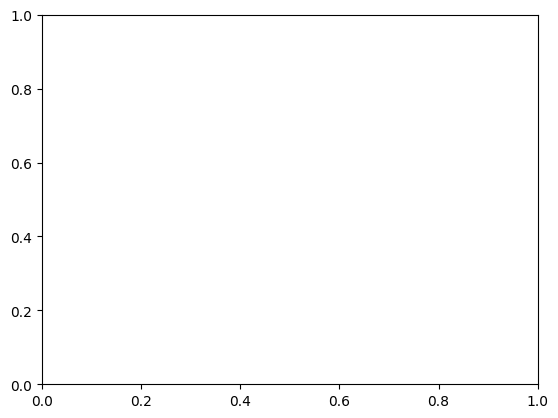

In [21]:
fig,ax = plt.subplots()
ax.plot([i for i in range(data_all.shape[0])],data_all["rfc"],label="Rf",c = "black")
ax.plot([i for i in range(data_all.shape[0])],data_all["rmc"],label="Rm",c = "c")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc"],label="Long-short ESG_Enhanced",c = "r")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc3"],label="Rf-Rm",c = "m")
ax.plot([i for i in range(data_all.shape[0])],data_all["dkc"],label="Long-short ESG",c = "g")
ax.set_xticks([0,10,20,30,40,50],[datetime.strftime(data_all["date"][i],"%Y-%m") for i in [0,10,20,30,40,50]])
ax.set_yticks([-30,-10,0,10,30,40],[str(i) + "%" for i in [-30,-10,0,10,30,40]])
ax.set_xlabel(r'$Time$')
ax.set_ylabel(r'$CTR$')
ax.legend()
plt.savefig("./result/all.jpg")
plt.show()

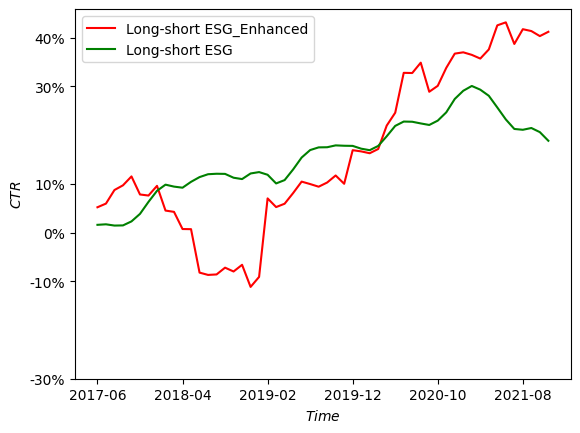

In [28]:
fig,ax = plt.subplots()
#ax.plot([i for i in range(data_all.shape[0])],data_all["rfc"],label="Rf",c = "black")
#ax.plot([i for i in range(data_all.shape[0])],data_all["rmc"],label="Rm",c = "c")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc"],label="Long-short ESG_Enhanced",c = "r")
#ax.plot([i for i in range(data_all.shape[0])],data_all["pickc3"],label="Rf-Rm",c = "m")
ax.plot([i for i in range(data_all.shape[0])],data_all["dkc"],label="Long-short ESG",c = "g")
ax.set_xticks([0,10,20,30,40,50],[datetime.strftime(data_all["date"][i],"%Y-%m") for i in [0,10,20,30,40,50]])
ax.set_yticks([-30,-10,0,10,30,40],[str(i) + "%" for i in [-30,-10,0,10,30,40]])
ax.set_xlabel(r'$Time$')
ax.set_ylabel(r'$CTR$')
ax.legend()
plt.savefig("./result/p1.jpg")
plt.show()

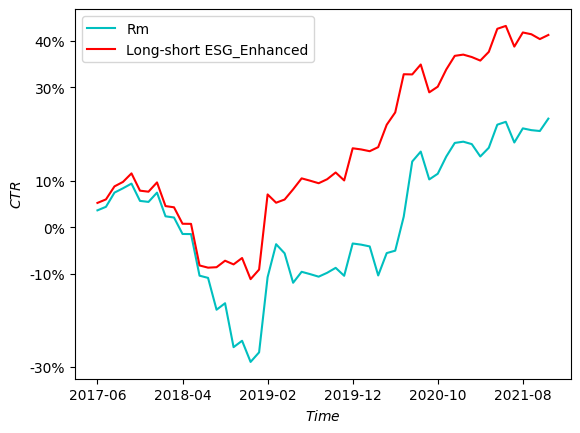

In [29]:
fig,ax = plt.subplots()
#ax.plot([i for i in range(data_all.shape[0])],data_all["rfc"],label="Rf",c = "black")
ax.plot([i for i in range(data_all.shape[0])],data_all["rmc"],label="Rm",c = "c")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc"],label="Long-short ESG_Enhanced",c = "r")
#ax.plot([i for i in range(data_all.shape[0])],data_all["pickc3"],label="Rf-Rm",c = "m")
#ax.plot([i for i in range(data_all.shape[0])],data_all["dkc"],label="Long-short ESG",c = "g")
ax.set_xticks([0,10,20,30,40,50],[datetime.strftime(data_all["date"][i],"%Y-%m") for i in [0,10,20,30,40,50]])
ax.set_yticks([-30,-10,0,10,30,40],[str(i) + "%" for i in [-30,-10,0,10,30,40]])
ax.set_xlabel(r'$Time$')
ax.set_ylabel(r'$CTR$')
ax.legend()
plt.savefig("./result/p2.jpg")
plt.show()

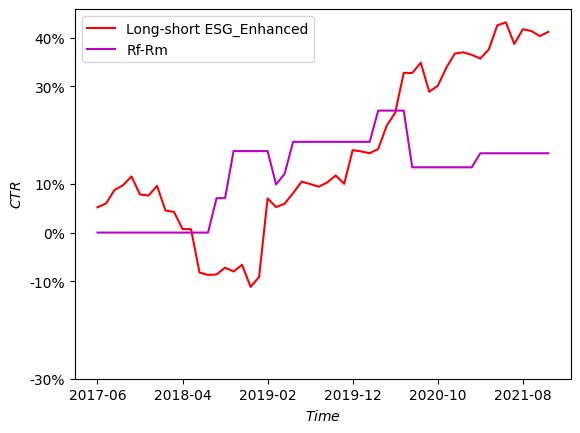

In [25]:
fig,ax = plt.subplots()
#ax.plot([i for i in range(data_all.shape[0])],data_all["rfc"],label="Rf",c = "black")
#ax.plot([i for i in range(data_all.shape[0])],data_all["rmc"],label="Rm",c = "c")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc"],label="Long-short ESG_Enhanced",c = "r")
ax.plot([i for i in range(data_all.shape[0])],data_all["pickc3"],label="Rf-Rm",c = "m")
#ax.plot([i for i in range(data_all.shape[0])],data_all["dkc"],label="Long-short ESG",c = "g")
ax.set_xticks([0,10,20,30,40,50],[datetime.strftime(data_all["date"][i],"%Y-%m") for i in [0,10,20,30,40,50]])
ax.set_yticks([-30,-10,0,10,30,40],[str(i) + "%" for i in [-30,-10,0,10,30,40]])
ax.set_xlabel(r'$Time$')
ax.set_ylabel(r'$CTR$')
ax.legend()
plt.savefig("./result/p3.jpg")
plt.show()